<a href="https://colab.research.google.com/github/patprem/FaceMorphingTool/blob/main/StyleGAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
NETWORK = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
STEPS = 300
FPS = 30
FREEZE_STEPS = 30

# Upload Starting Image

Choose your starting image.

In [ ]:
import os
from google.colab import files

uploaded = files.upload()
if len(uploaded) != 1:
  print("Upload exactly 1 file for source.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    SOURCE_NAME = f"source{ext}"
    open(SOURCE_NAME, 'wb').write(v)

Saving gettyimages-1183457760-612x612.jpg to gettyimages-1183457760-612x612.jpg


Also, choose your ending image.

In [ ]:
uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for target.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    TARGET_NAME = f"target{ext}"
    open(TARGET_NAME, 'wb').write(v)

Saving Prathik B Passport Sized Photo.jpg to Prathik B Passport Sized Photo.jpg


# Install Software

Some software must be installed into Colab, for this notebook to work. We are specificially using these technologies:

* [Training Generative Adversarial Networks with Limited Data](https://arxiv.org/abs/2006.06676)
Tero Karras, Miika Aittala, Janne Hellsten, Samuli Laine, Jaakko Lehtinen, Timo Aila
* [One millisecond face alignment with an ensemble of regression trees](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf) Vahid Kazemi, Josephine Sullivan


In [ ]:
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2

--2021-12-16 09:38:33--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2’

shape_predictor_5_f 100%[===================>]   5.44M  21.5MB/s    in 0.3s    

2021-12-16 09:38:33 (21.5 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2’ saved [5706710/5706710]

bzip2: Output file shape_predictor_5_face_landmarks.dat already exists.


In [ ]:
import sys
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
sys.path.insert(0, "/content/stylegan2-ada-pytorch")

fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.


# Preprocess Images for Best StyleGAN Results

The following are helper functions for the preprocessing.

In [ ]:
import cv2
import numpy as np
from PIL import Image
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

def find_eyes(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 0)
  
  if len(rects) == 0:
    raise ValueError("No faces detected")
  elif len(rects) > 1:
    raise ValueError("Multiple faces detected")

  shape = predictor(gray, rects[0])
  features = []

  for i in range(0, 5):
    features.append((i, (shape.part(i).x, shape.part(i).y)))

  return (int(features[3][1][0] + features[2][1][0]) // 2, \
    int(features[3][1][1] + features[2][1][1]) // 2), \
    (int(features[1][1][0] + features[0][1][0]) // 2, \
    int(features[1][1][1] + features[0][1][1]) // 2)

def crop_stylegan(img):
  left_eye, right_eye = find_eyes(img)
  d = abs(right_eye[0] - left_eye[0])
  z = 255/d
  ar = img.shape[0]/img.shape[1]
  w = img.shape[1] * z
  img2 = cv2.resize(img, (int(w), int(w*ar)))
  bordersize = 1024
  img3 = cv2.copyMakeBorder(
      img2,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_REPLICATE)

  left_eye2, right_eye2 = find_eyes(img3)

  crop1 = left_eye2[0] - 385 
  crop0 = left_eye2[1] - 490
  return img3[crop0:crop0+1024,crop1:crop1+1024]

The following will preprocess and crop your images.  If you receive an error indicating multiple faces were found, try to crop your image better or obscure the background.  If the program does not see a face, then attempt to obtain a clearer and more high-resolution image.

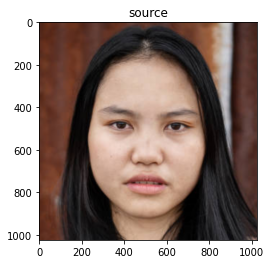

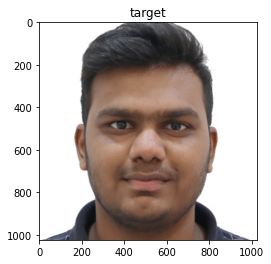

True

In [ ]:
from matplotlib import pyplot as plt
import cv2

image_source = cv2.imread(SOURCE_NAME)
if image_source is None:
    raise ValueError("Source image not found")

image_target = cv2.imread(TARGET_NAME)
if image_target is None:
    raise ValueError("Source image not found")

cropped_source = crop_stylegan(image_source)
cropped_target = crop_stylegan(image_target)

img = cv2.cvtColor(cropped_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

img = cv2.cvtColor(cropped_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target')
plt.show()

cv2.imwrite("cropped_source.png", cropped_source)
cv2.imwrite("cropped_target.png", cropped_target)

#print(find_eyes(cropped_source))
#print(find_eyes(cropped_target))

# Convert Source to a GAN

First, we convert the source to a GAN latent vector.  This process will take several minutes.

In [ ]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_source --target=cropped_source.png --network={NETWORK}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/1000: dist 0.64 loss 24569.53
step    2/1000: dist 0.52 loss 27642.74
step    3/1000: dist 0.57 loss 27167.59
step    4/1000: dist 0.57 loss 26253.69
step    5/1000: dist 0.59 loss 24958.55
step    6/1000: dist 0.50 loss 23356.06
step    7/1000: dist 0.55 loss 21513.72
step    8/1000: dist 0.45 loss 19485.98
step    9/1000: dist 0.59 loss 17342.24
step   10/1000: dist 0.55 loss 15145.47
step   11/1000: dist 0.49 loss 12946.06
step   12/1000: dist 0.53 loss 10817.87
step   13/1000: dist 0.52 loss 8803.69
step   14/1000: dist 0.50 loss 6948.97
step   15/1000: dist 0.55 loss 5315.48
step   16/1000: dist 0.49 loss 3971.71
step   17/1000: dist 0.51 loss 2944.83
step   18/1000: dist 0.53 loss 2212.46
step   19/1000: dist 0

# Convert Target to a GAN

Next, we convert the target to a GAN latent vector.  This process will also take several minutes.

In [ ]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_target --target=cropped_target.png --network={NETWORK}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/1000: dist 0.55 loss 24569.43
step    2/1000: dist 0.59 loss 27642.82
step    3/1000: dist 0.53 loss 27167.56
step    4/1000: dist 0.50 loss 26253.62
step    5/1000: dist 0.56 loss 24958.53
step    6/1000: dist 0.53 loss 23356.09
step    7/1000: dist 0.51 loss 21513.68
step    8/1000: dist 0.55 loss 19486.07
step    9/1000: dist 0.56 loss 17342.21
step   10/1000: dist 0.43 loss 15145.35
step   11/1000: dist 0.48 loss 12946.05
step   12/1000: dist 0.48 loss 10817.83
step   13/1000: dist 0.41 loss 8803.58
step   14/1000: dist 0.46 loss 6948.92
step   15/1000: dist 0.37 loss 5315.30
step   16/1000: dist 0.43 loss 3971.64
step   17/1000: dist 0.38 loss 2944.70
step   18/1000: dist 0.43 loss 2212.37
step   19/1000: dist 0

With the conversion complete, lets have a look at the two GANs.

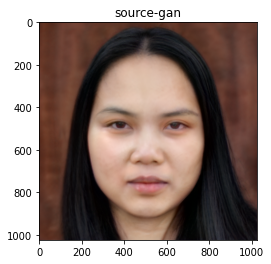

In [ ]:
img_gan_source = cv2.imread('/content/out_source/proj.png')
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source-gan')
plt.show()

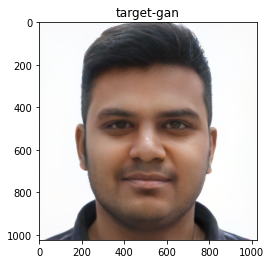

In [ ]:
img_gan_target = cv2.imread('/content/out_target/proj.png')
img = cv2.cvtColor(img_gan_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target-gan')
plt.show()

# Build the Video

The following code builds a transition video between the two latent vectors previously obtained.

In [ ]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

lvec1 = np.load('/content/out_source/projected_w.npz')['w']
lvec2 = np.load('/content/out_target/projected_w.npz')['w']

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer('/content/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1
   
  for i in range(repeat):
    video.append_data(synth_image)
  current = current + step


video.close()

  0%|          | 0/300 [00:00<?, ?it/s]

# Download your Video

If you made it through all of these steps, you are now ready to download your video.

In [ ]:
from google.colab import files
files.download("movie.mp4") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>